<center>
<img src="../../img/ods_stickers.jpg">
## Открытый курс по машинному обучению
</center>
<center>Автор материала: аналитик-разработчик в команде Яндекс.Метрики Мария Мансурова

# <center> Домашнее задание № 9
## <center> Анализ временных рядов

In [230]:
import pandas as pd
import os

from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly import graph_objs as go
import requests
import pandas as pd

print(__version__) # need 1.9.0 or greater

init_notebook_mode(connected = True)




def plotly_df(df, title = ''):
    data = []
    
    for column in df.columns:
        trace = go.Scatter(
            x = df.index,
            y = df[column],
            mode = 'lines',
            name = column
        )
        data.append(trace)
    
    layout = dict(title = title)
    fig = dict(data = data, layout = layout)
    iplot(fig, show_link=False)

2.0.1


## Подготавливаем данные

Для начала скачаем данные в `dataframe`. Сегодня будем предсказывать просмотры wiki-страницы [Machine Learning](https://en.wikipedia.org/wiki/Machine_learning). Данные я скачала с помощью библиотеки [Wikipediatrend](https://www.r-bloggers.com/using-wikipediatrend/) для `R`.

In [231]:
df = pd.read_csv('../../data/wiki_machine_learning.csv', sep = ' ')
df = df[df['count'] != 0]
df.head()

,date,count,lang,page,rank,month,title
81,2015-01-01,1414,en,Machine_learning,8708,201501,Machine_learning
80,2015-01-02,1920,en,Machine_learning,8708,201501,Machine_learning
79,2015-01-03,1338,en,Machine_learning,8708,201501,Machine_learning
78,2015-01-04,1404,en,Machine_learning,8708,201501,Machine_learning
77,2015-01-05,2264,en,Machine_learning,8708,201501,Machine_learning


In [232]:
df.shape

(383, 7)

In [233]:
df.date = pd.to_datetime(df.date)

In [234]:
plotly_df(df.set_index('date')[['count']])

## Предсказание с помощью Facebook Prophet

Для начала построим предсказание с помощью простой библиотеки `Facebook Prophet`. Для того, чтобы посмотреть на качество модели, отбросим из обучающей выборки последние 30 дней.

In [235]:
from fbprophet import Prophet

In [236]:
predictions = 30

df = df[['date', 'count']]
df.columns = ['ds', 'y']
train_df = df[:-predictions].copy()

In [177]:
model = Prophet(yearly_seasonality=True)
model.fit(train_df)

In [178]:
future = model.make_future_dataframe(periods=30)
future.tail()

,ds
378,2016-01-16
379,2016-01-17
380,2016-01-18
381,2016-01-19
382,2016-01-20


In [179]:
forecast = model.predict(future)
forecast.tail()

,ds,t,trend,seasonal_lower,seasonal_upper,trend_lower,trend_upper,yhat_lower,yhat_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,seasonal,yhat
378,2016-01-16,1.073446,2946.748331,-461.131891,-461.131891,2946.748225,2946.748431,2096.804564,2866.325469,-860.441386,-860.441386,-860.441386,399.309494,399.309494,399.309494,-461.131891,2485.616440
379,2016-01-17,1.076271,2949.752360,-303.591130,-303.591130,2949.752245,2949.752464,2293.459619,3017.393579,-720.143785,-720.143785,-720.143785,416.552654,416.552654,416.552654,-303.591130,2646.161230
380,2016-01-18,1.079096,2952.756388,713.816039,713.816039,2952.756265,2952.756500,3292.709948,4006.462444,282.577995,282.577995,282.577995,431.238044,431.238044,431.238044,713.816039,3666.572427
381,2016-01-19,1.081921,2955.760417,981.307220,981.307220,2955.760287,2955.760535,3554.316647,4292.870481,538.054284,538.054284,538.054284,443.252936,443.252936,443.252936,981.307220,3937.067637
382,2016-01-20,1.084746,2958.764445,874.202169,874.202169,2958.764307,2958.764569,3464.272100,4196.759023,421.678742,421.678742,421.678742,452.523426,452.523426,452.523426,874.202169,3832.966614


In [180]:
round(forecast['yhat'][-1:])

382    3833.0
Name: yhat, dtype: float64

**Вопрос 1:** Какое предсказание числа просмотров wiki-страницы на 20 января? Ответ округлите до целого числа.

Оценим качество предсказания по последним 30 точкам.

In [181]:
import numpy as np
cmp_df = forecast.set_index('ds')[['yhat', 'yhat_lower', 'yhat_upper']].join(df.set_index('ds'))
cmp_df['e'] = cmp_df['y'] - cmp_df['yhat']
cmp_df['p'] = 100*cmp_df['e']/cmp_df['y']
print('MAPE', np.mean(abs(cmp_df[-predictions:]['p'])))
print('MAE', np.mean(abs(cmp_df[-predictions:]['e'])))

MAPE 38.3882717622
MAE 713.01104297


**Вопрос 2**: Какое получилось MAPE?

**Вопрос 3**: Какое получилось MAE?

## Предсказываем с помощью ARIMA

In [182]:
%matplotlib inline
import matplotlib.pyplot as plt
from scipy import stats
import statsmodels.api as sm

           ds     y
81 2015-01-01  1414
80 2015-01-02  1920
79 2015-01-03  1338
78 2015-01-04  1404
77 2015-01-05  2264


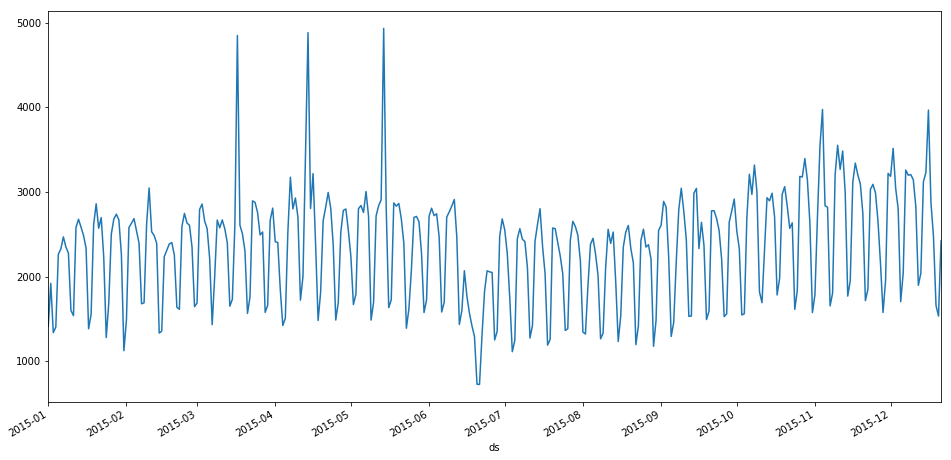

In [239]:
print(train_df.head())
train_df.index = train_df['ds']
train_df['y'].plot()

**Вопрос 4:** Проверим стационарность ряда с помощью критерия Дики-Фулера. Является ли ряд стационарным? Какое значение p-value?

In [240]:
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(train_df['y'])[1])

Критерий Дики-Фуллера: p=0.107392


In [247]:
train_df['y'] = train_df['y'] - train_df['y'].shift(7)
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(train_df['y'][7:])[1])

Критерий Дики-Фуллера: p=0.000000


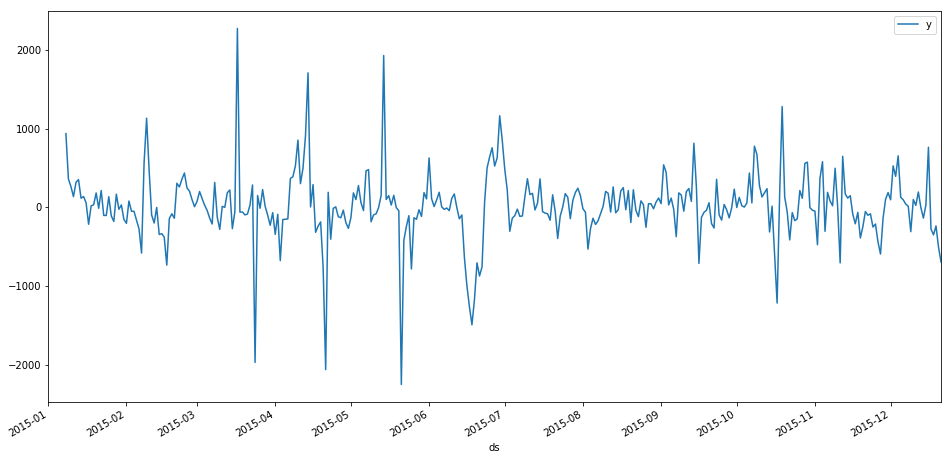

In [248]:
train_df.plot()

**Вопрос 5**: Далее перейдем к построению модели SARIMAX (`sm.tsa.statespace.SARIMAX`). Модель c какими параметрами лучшая по `AIC`-критерию?

In [249]:
p = 1
ds = range(0, 2)
q = 2
P = 3
Ds = range(0, 3)
Qs = range(0, 2)

In [250]:
from itertools import product
parameters = product(Ds, ds, Qs)
parameters_list = list(parameters)
len(parameters_list)

12

In [251]:
%%time
from tqdm import tqdm
results = []
best_aic = float("inf")



for param in tqdm(parameters_list):
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(train_df['y'], order=(p, param[1], q), 
                                        seasonal_order=(P, param[0], param[2], 7)).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])

 17%|█▋        | 2/12 [00:16<01:19,  7.95s/it]       | 1/12 [00:07<01:24,  7.68s/it]/usr/local/lib/python3.5/dist-packages/statsmodels/tsa/statespace/tools.py:405: RuntimeWarning:

invalid value encountered in sqrt

 33%|███▎      | 4/12 [00:19<00:37,  4.75s/it]/usr/local/lib/python3.5/dist-packages/statsmodels/base/model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

 67%|██████▋   | 8/12 [00:52<00:23,  6.00s/it]/usr/local/lib/python3.5/dist-packages/statsmodels/base/model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

 75%|███████▌  | 9/12 [01:15<00:33, 11.05s/it]/usr/local/lib/python3.5/dist-packages/statsmodels/base/model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

100%|██████████| 12/12 [02:03<00:00, 11.51s/it]

CPU times: user 1min 18s, sys: 3min 1s, total: 4min 19s
Wall time: 2min 3s


In [252]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True))

   parameters          aic
0   (0, 0, 0)  5020.963352
1   (0, 0, 1)  5021.558923
5   (1, 0, 1)  5083.499723
4   (1, 0, 0)  5164.557176
8   (2, 0, 0)  5307.134667
9   (2, 0, 1)  5337.410335
2   (0, 1, 0)          NaN
3   (0, 1, 1)          NaN
6   (1, 1, 0)          NaN
7   (1, 1, 1)          NaN
10  (2, 1, 0)          NaN
11  (2, 1, 1)          NaN
